En este caso no suponemos homogeneidad:
- $f_{1}$ tiene densidad $N_{r}(\mu_{1}, \Sigma_1)$
- $f_{2}$ tiene densidad $N_{r}(\mu_{2}, \Sigma_2)$
- $\Sigma_{1}\neq \Sigma_{2}$ (no homogéneo)

Así, podemos 
$$\log\left(\frac{f_{1}\pi_{1}}{f_{2}\pi_{2}} \right)= cuadrático$$

### Importación de librerías

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from sklearn import linear_model, datasets
import seaborn as sns
import itertools

%matplotlib inline
sns.set()

import warnings
warnings.filterwarnings('ignore')
# displaying the warning message 
warnings.warn('UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names')

### Definiciones:

In [2]:
def multivariate_gaussian_pdf(X,MU,SIGMA):
    X = X.reshape(-1,1)
    MU = MU.reshape(-1,1)
    p,_ = SIGMA.shape

    
    SIGMA_inv = np.linalg.inv(SIGMA)
    den = np.sqrt((2 * np.pi)**p * np.linalg.det(SIGMA))
    exp = -(1/2) * ((X - MU).T @ SIGMA_inv @ (X - MU))
    
    
    return float((1. / den) * np.exp(exp) )   

def calculate_boundary(X,MU_k,MU_l, SIGMA,pi_k,pi_l): 
    return (np.log(pi_k / pi_l) - 1/2 * (MU_k + MU_l).T @ np.linalg.inv(SIGMA)@(MU_k - MU_l) + X.T @ np.linalg.inv(SIGMA)@ (MU_k - MU_l)).flatten()[0]   


def LDA_score(X,MU_k,SIGMA,pi_k): 
 
    return (np.log(pi_k) - 1/2 * (MU_k).T @ np.linalg.inv(SIGMA)@(MU_k) + X.T @ np.linalg.inv(SIGMA)@ (MU_k)).flatten()[0]   

def predict_LDA_class(X,MU_list,SIGMA,pi_list): 

    scores_list = []
    classes = len(MU_list)
    
    for p in range(classes):
        score = LDA_score(X.reshape(-1,1),MU_list[p].reshape(-1,1),sigma,pi_list[0]) 
        scores_list.append(score)
             
    return np.argmax(scores_list)

def QDA_score(X,MU_k,SIGMA,pi_k): 
   
    SIGMA_inv = np.linalg.inv(SIGMA)
    
    return (np.log(pi_k) - 1/2 * np.log(np.linalg.det(SIGMA_inv)) - 1/2 * (X - MU_k).T @ SIGMA_inv @ (X - MU_k)).flatten()[0]   

def predict_QDA_class(X,MU_list,SIGMA_list,pi_list): 
    scores_list = []
    classes = len(MU_list)
    
    for p in range(classes):
        score = QDA_score(X.reshape(-1,1),MU_list[p].reshape(-1,1),SIGMA_list[p],pi_list[p]) 
        scores_list.append(score)
             
    return np.argmax(scores_list)

## Base de datos de Iris

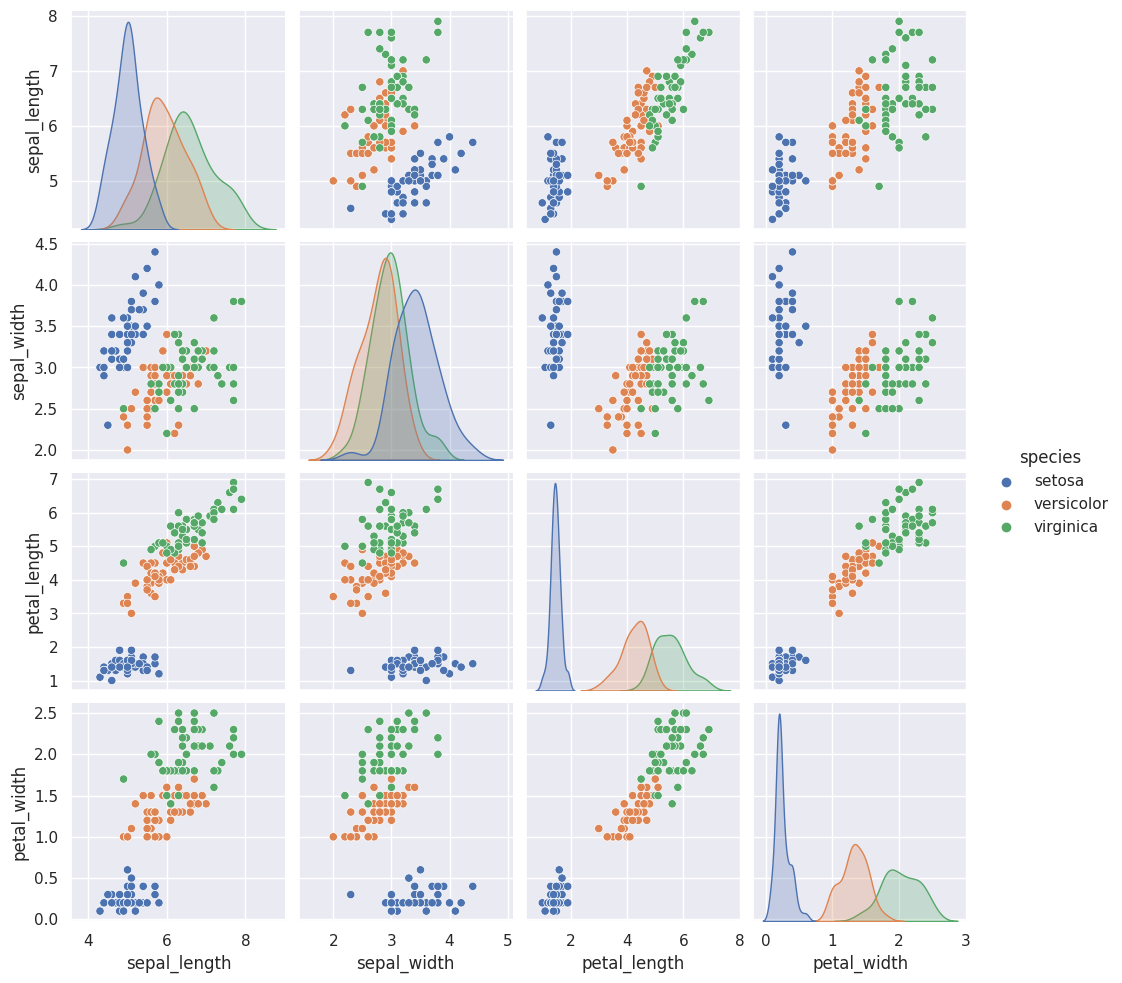

In [3]:
iris = sns.load_dataset("iris")
sns.pairplot(iris, hue="species")

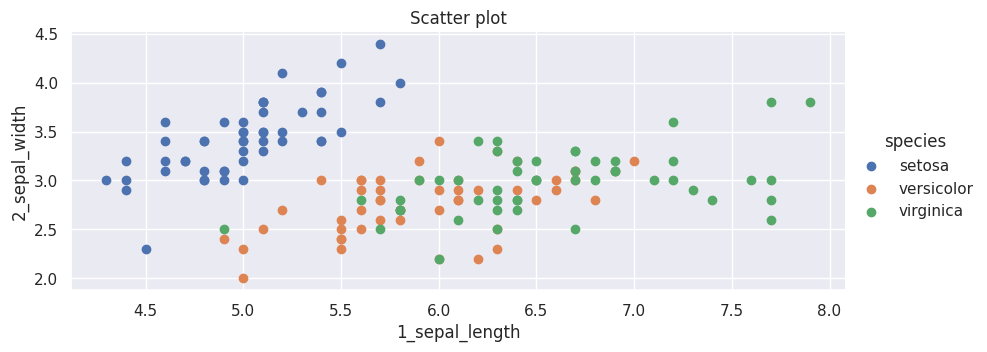

In [4]:
iris = iris.rename(index = str, columns = {'sepal_length':'1_sepal_length','sepal_width':'2_sepal_width', 'petal_length':'3_petal_length', 'petal_width':'4_petal_width'})
sns.FacetGrid(iris, hue="species", height=3.5, aspect=2.5) .map(plt.scatter,"1_sepal_length", "2_sepal_width", )  .add_legend()
plt.title('Scatter plot')
df1 = iris[["1_sepal_length", "2_sepal_width",'species']]

### LDA

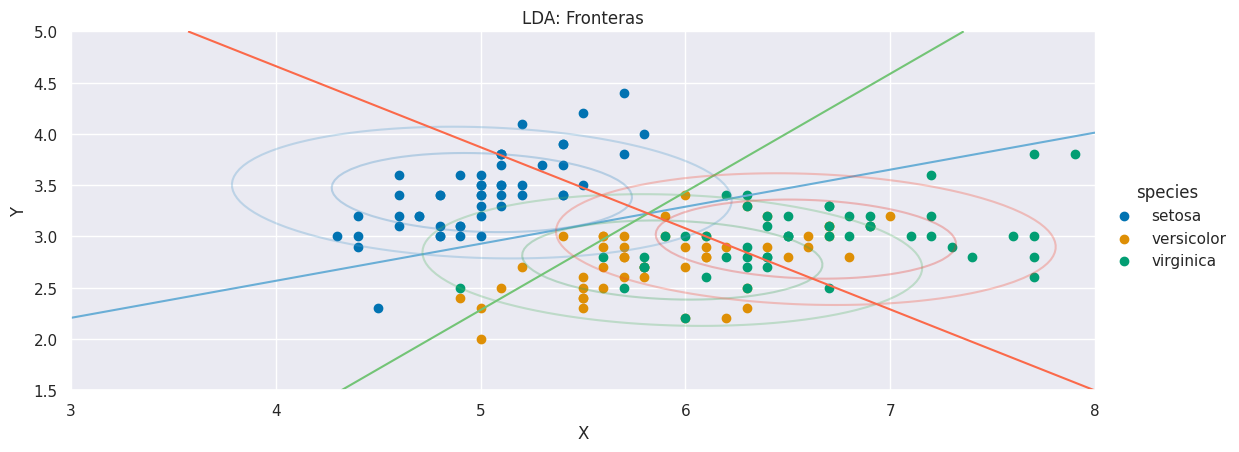

In [5]:
mu_list = np.split(df1.groupby('species').mean().values,[1,2])
sigma = df1.cov().values
pi_list = df1.iloc[:,2].value_counts().values / len(df1)


N = 100
X = np.linspace(3, 8, N)
Y = np.linspace(1.5, 5, N)
X, Y = np.meshgrid(X, Y)


color_list = ['Blues','Greens','Reds']
my_norm = colors.Normalize(vmin=-1.,vmax=1.)

g = sns.FacetGrid(iris, hue="species", palette = 'colorblind', height=4.5, aspect=2.5) .map(plt.scatter,"1_sepal_length", "2_sepal_width", )  .add_legend()
my_ax = g.ax

for i,v in enumerate(itertools.combinations([0,1,2],2)):
    mu = mu_list[i]
    Sigma = sigma

    zz = np.array(  [multivariate_gaussian_pdf( np.array([xx,yy]).reshape(-1,1), mu, Sigma) 
                     for xx, yy in zip(np.ravel(X), np.ravel(Y)) ] )
    
    bb = np.array(  [ calculate_boundary(np.array([xx,yy]).reshape(-1,1),mu_list[v[0]].reshape(-1,1),mu_list[v[1]].reshape(-1,1), sigma , .33,.33)
                     for xx, yy in zip(np.ravel(X), np.ravel(Y)) ] )
    
  
    Z = zz.reshape(X.shape)
    B = bb.reshape(X.shape)


    my_ax.contour( X, Y, Z, 3,cmap = color_list[i] , norm = my_norm, alpha = .3)

    my_ax.contour( X, Y, B , levels = [0] ,cmap = color_list[i]  , norm = my_norm)

    


my_ax.set_xlabel('X')
my_ax.set_ylabel('Y')
my_ax.set_title('LDA: Fronteras')

plt.show()

In [6]:
X_data = df1.iloc[:,0:2]
y_labels = df1.iloc[:,2].replace({'setosa':0,'versicolor':1,'virginica':2}).copy()

y_pred = np.array(  [predict_LDA_class( np.array([xx,yy]).reshape(-1,1), mu_list, Sigma, pi_list) 
                     for xx, yy in zip(np.ravel(X_data.values[:,0]), np.ravel(X_data.values[:,1])) ] )
display(np.mean(y_pred == y_labels))

0.7866666666666666

### QDA

In [7]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
X_data = df1.iloc[:,0:2]
y_labels = df1.iloc[:,2].replace({'setosa':0,'versicolor':1,'virginica':2}).copy()

qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X_data,y_labels)

QuadraticDiscriminantAnalysis(store_covariance=True)

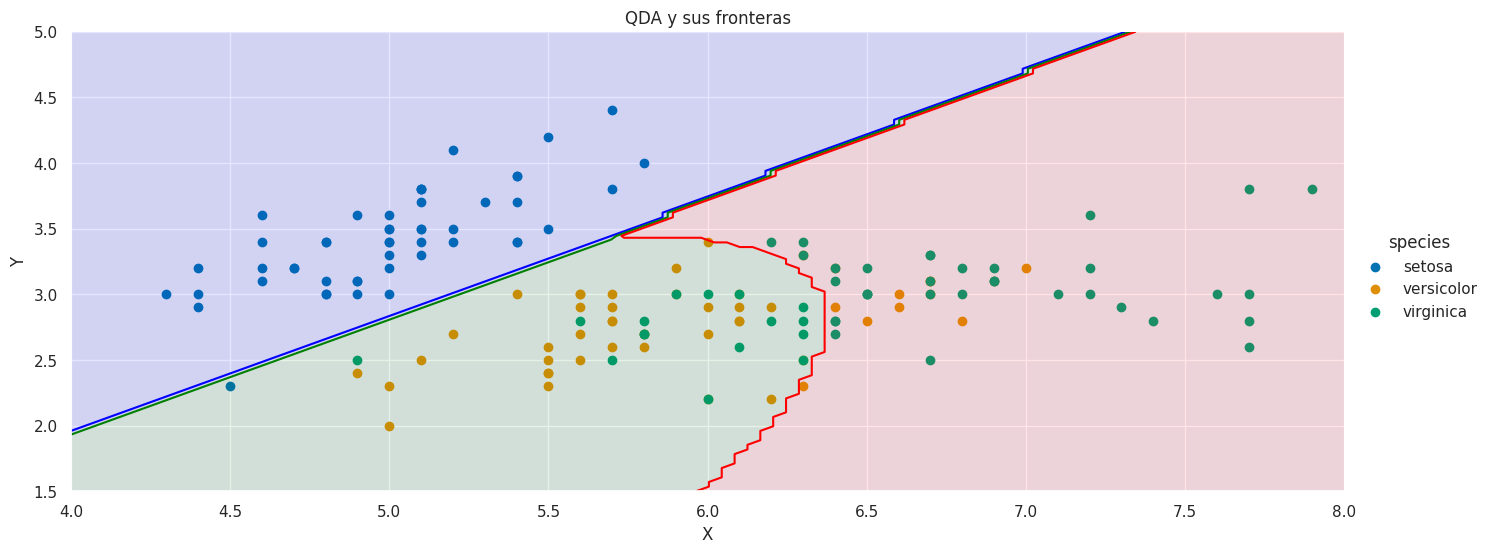

In [8]:

mu_list = np.split(df1.groupby('species').mean().values,[1,2])
sigma_list = np.split(df1.groupby('species').cov().values,[2,4], axis = 0)
pi_list = df1.iloc[:,2].value_counts().values / len(df1)


N = 100
X = np.linspace(4, 8, N)
Y = np.linspace(1.5, 5, N)
X, Y = np.meshgrid(X, Y)


color_list = ['Blues','Greens','Reds']
my_norm = colors.Normalize(vmin=-1.,vmax=1.)

g = sns.FacetGrid(iris, hue="species", palette = 'colorblind', height=5.5, aspect=2.5) .map(plt.scatter, "1_sepal_length", "2_sepal_width",)  .add_legend()
my_ax = g.ax



zz = np.array(  [qda.predict( np.array([[xx,yy]])) 
                     for xx, yy in zip(np.ravel(X), np.ravel(Y)) ] )
    

Z = zz.reshape(X.shape)



my_ax.contourf( X, Y, Z, 2, alpha = .1, colors = ('blue','green','red'))
my_ax.contour( X, Y, Z, 2, alpha = 1, colors = ('blue','green','red'))


my_ax.set_xlabel('X')
my_ax.set_ylabel('Y')
my_ax.set_title('QDA y sus fronteras')

plt.show()

In [9]:

y_pred = np.array(  [predict_QDA_class( np.array([xx,yy]).reshape(-1,1), mu_list, sigma_list, pi_list) 
                     for xx, yy in zip(np.ravel(X_data.values[:,0]), np.ravel(X_data.values[:,1])) ] )
display(np.mean(y_pred == y_labels))


display(qda.score(X_data,y_labels))

0.7866666666666666

0.8